In [13]:
## imports
## %matplotlib qt


import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import matplotlib
from matplotlib import cm
import h5py
import os
from math import pi, sqrt, atan, degrees
from scipy.optimize import curve_fit
import scipy
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import time
from scipy.interpolate import InterpolatedUnivariateSpline
rc('text', usetex=True)
import seaborn as sns
from os import path
from scipy import integrate

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3


In [15]:
## Data helper functions

def CutTimes(time, data, TLow, TUp): 
    TLowIndex = np.where(time <= TLow)[0][0]
    TUpIndex = np.where(time >= TUp)[0][-1]
    time = time[TLowIndex:TUpIndex]
    data = data[TLowIndex:TUpIndex]
    return time, data

def CutTimesArray(time, Arr, TLow, TUp): 
    TLowIndex = np.where(time <= TLow)[0] 
    if(len(TLowIndex) > 0):
        TLowIndex = TLowIndex[-1]
    else:
        TLowIndex = 0
    TUpIndex = np.where(time >= TUp)[0]
    if(len(TUpIndex) > 0):
        TUpIndex = TUpIndex[0]
    else:
        TUpIndex = -1
        
    time = time[TLowIndex:TUpIndex]
    Ans = []
    for data in Arr:
        Ans.append(data[TLowIndex:TUpIndex])
    return time, Ans 


def GetPeakTimeMode(time, data): ###
    ## Peak time being the peak of the magnitude of the data
    t_peak = time[np.argmax(np.absolute(data))]
    return t_peak

def GetPeakTimeModeReal(time, data): ###
    ## Peak time being the peak of the magnitude of the data
    t_peak = time[np.argmax(np.real(data))]
    return t_peak

def SubtractPeakTimeMode(time, data): ###
    t_peak = GetPeakTimeMode(time, data)
    return time - t_peak

def SubtractPeakTimeModeReal(time, data): ###
    t_peak = GetPeakTimeModeReal(time, data)
    return time - t_peak

def InterpolateTimes(time, data, time_dest):
    """ Interpolates time, data onto new time axis
        time_dest """
    interpolant = scipy.interpolate.CubicSpline(time, data)
    return interpolant(time_dest)

def ComputeAperatureAngle(Radius):
    """ Compute the aperature angle """
    Distance = 26.33 # The distance we're using for this head-on run
    alpha = 2.0 * atan(Distance/(2*Radius))
    return degrees(alpha)

ComputeAperatureAngle(100)

ComputeAperatureAngle(220)

6.849095471271595

## Read and plot GW data

In [3]:
## Data reading functions

def GetWaveformRadius(p, rad):
    psi4_file = p + 'GW2/rPsi4_FiniteRadii_CodeUnits.h5'
    f = h5py.File(psi4_file, 'r')
    radius = sorted(f.keys())[rad]
    coord_radius = f[radius]['CoordRadius.dat'][0][1]
    return coord_radius
    
def GetPsi4Mode(p, mode, radius=-1): 
    ## which finite radius should we use?
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'GW2/rPsi4_FiniteRadii_CodeUnits.h5' 
    f = h5py.File(psi4_file, 'r')
    radius = sorted(f.keys())[radius]
    data = f[radius]['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    Psi4 = re + 1j*im
    return time, Psi4

def GetStrainMode(p, mode, radius=-1): 
    ## which finite radius should we use?
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'GW2/rh_FiniteRadii_CodeUnits.h5' 
    f = h5py.File(psi4_file, 'r')
    radius = sorted(f.keys())[radius]
    data = f[radius]['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    Psi4 = re + 1j*im
    return time, Psi4

def GetPsi4ModeExtrapolated(p, mode, order=2): 
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'rMPsi4_Asymptotic_GeometricUnits.h5' 
    f = h5py.File(psi4_file, 'r')
    data = f['Extrapolated_N' + str(order) +'.dir']['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    Psi4 = re + 1j*im
    return time, Psi4

def GetStrainModeExtrapolated(p, mode, order=2): 
    l = mode[0]
    m = mode[1]
    h_file = p + 'rhOverM_Asymptotic_GeometricUnits.h5' 
    f = h5py.File(h_file, 'r')
    data = f['Extrapolated_N'+str(order)+'.dir']['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    h = re + 1j*im
    return time, h

def GetCCEWaveform(p, rad): 
    h_file = p + 'CCE/CharacteristicExtractVolume0_' + rad +'.h5' 
    f = h5py.File(h_file, 'r')
    data = f['Strain.dat']
    
    def lm_index(l, m):
        return 2 * (l**2 + l + m) + 1

    index = lm_index(2,2)
    print(index)
    time = data[:,0]
    real = data[:,index]
    imag = data[:,index+1]
    mode = real + 1j*imag
    return time, mode


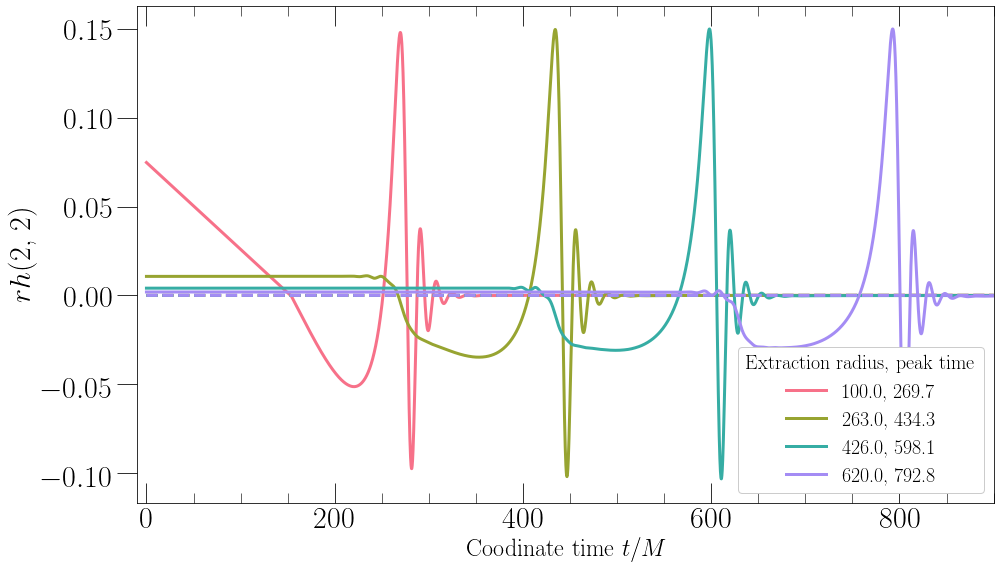

17
17
17
17


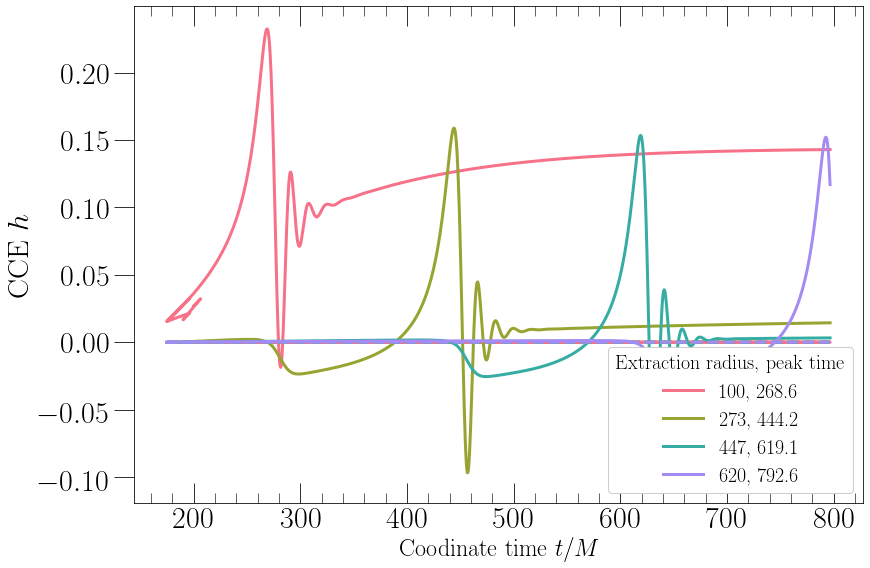

[100, 103, 106, 111, 116, 121, 128, 134, 141, 148, 157, 166, 177, 190, 203, 220, 240, 263, 291, 325, 369, 426, 505, 620]
17
17
17
17


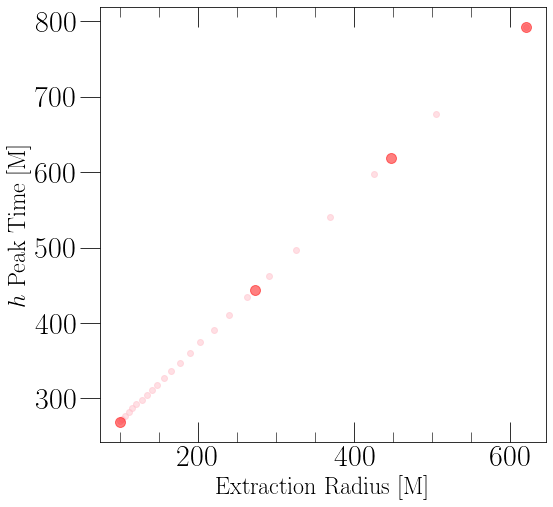

In [31]:
## Plot CCE waveform strain at various radii
def PlotRadiiCCE(p):
    ## Run Progress
    plt.figure(figsize=(12, 8))
 
    radii = ['100', '273', '447', '620']
    cs = sns.color_palette('husl', n_colors=len(radii))
    
    for rad, color in zip(radii, cs):
        time, data = GetCCEWaveform(p, rad)
        tt = GetPeakTimeMode(time, np.absolute(data))
        plt.plot(time, np.real(data), color=color, label=rad +', %.1f' % (tt))
        plt.plot(time, np.imag(data), '--', color=color)
    
    plt.xlabel(r'Coodinate time $t/M$')
    plt.ylabel(r'CCE $h$', fontsize=30)
    legend = plt.legend(loc='lower right', title='Extraction radius, peak time', fontsize=20, framealpha=1.0)
    plt.setp(legend.get_title(),fontsize=20)
    #plt.xlim(min(time), min(time) + 400)
    plt.tight_layout()
    plt.savefig('CCERadiiStrain.pdf')
    plt.show()
    
def PlotRadiiStrain(p):
    ## Run Progress
    plt.figure(figsize=(14, 8))

    mode = (2,2)
    
    #radii = [0, 15, 20, 22, 23]
    radii = [0, 17, 21, 23]
    cs = sns.color_palette('husl', n_colors=len(radii))

    for rad, i in zip(radii, range(len(radii))):

        radius = int(GetWaveformRadius(p, rad))
        
        time, data = GetStrainMode(p, mode, radius=rad)
        tt = GetPeakTimeMode(time,np.absolute(data))
        plt.plot(time, np.real(data), label='%.1f, %.1f' % (radius, tt), color=cs[i])
        plt.plot(time, np.imag(data), '--', color=cs[i])

    plt.xlabel(r'Coodinate time $t/M$')
    plt.ylabel(r'$rh$' + str(mode), fontsize=30)
    legend = plt.legend(loc='lower right', title='Extraction radius, peak time', fontsize=20, framealpha=1.0)
    plt.setp(legend.get_title(),fontsize=20)
    plt.xlim(-10, 900)
    plt.tight_layout()
    plt.savefig('RadiiPeaks.pdf')
    plt.show()
    
def PlotPeakTimes(p):
    
    plt.figure(figsize=(8, 8))
    
    ## Strain times
    rads = range(24)
    peak_times = []
    radii = []
    
    for rad in rads:
        radius = int(GetWaveformRadius(p, rad))
        time, data = GetStrainMode(p, (2,2), radius=rad)
        tt = GetPeakTimeMode(time,np.absolute(data))
        peak_times.append(tt)
        radii.append(radius)
        
    plt.plot(radii, peak_times, 'o', color='pink', alpha=0.5)
    print(radii)
    
    ## CCE times
    cce_rads = [100, 273, 447, 620]
    cce_peak_times = []
    for rad in cce_rads:
        time, data = GetCCEWaveform(p, str(rad))
        tt = GetPeakTimeMode(time, np.absolute(data))
        cce_peak_times.append(tt)
    
    plt.plot(cce_rads, cce_peak_times, 'o', markersize = 10, color='red', alpha=0.5)
    
    plt.xlabel('Extraction Radius [M]')
    plt.ylabel('$h$ Peak Time [M]')
    plt.show()
    
PlotRadiiStrain('Data/JoinedLev2/')
PlotRadiiCCE('Data/JoinedLev2/')
PlotPeakTimes('Data/JoinedLev2/')

## Isotropic sphere distribution

In [ ]:
## Isotropic sphere plot
def SpherePlot():
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    
    ## Sphere radius
    R = 100
    
    ## Plot mesh sphere
    u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi:100j]
    x = R*np.cos(u)*np.sin(v)
    y = R*np.sin(u)*np.sin(v)
    z = R*np.cos(v)
    #ax.plot_wireframe(x, y, z, color="blue", linewidth=0.1)
    
    
    ## Camera coordinates
    theta_points = 10
    phi_points = 20
    
    cs = sns.color_palette('husl', n_colors=phi_points)
    for u, i in zip(np.linspace(0, 2*pi, phi_points), range(phi_points)):
        x = []
        y = []
        z = []
        for v in np.linspace(0, pi, theta_points):
            x.append(R*np.cos(u)*np.sin(v))
            y.append(R*np.sin(u)*np.sin(v))
            z.append(R*np.cos(v))
            #print(int(R*np.cos(u)*np.sin(v)), int(R*np.sin(u)*np.sin(v)), int(R*np.cos(v)))
        ax.scatter(x, y, z, s=100, color=cs[i])
            
            
        
    #u, v = np.mgrid[0:2*np.pi:points, 0:np.pi:points]
    #x = R*np.cos(u)*np.sin(v)
    #y = R*np.sin(u)*np.sin(v)
    #z = R*np.cos(v)
    
    #ax.plot_wireframe(x, y, z, color="b", linewidth=0.1)
    
    
    ax.set_xlabel('Camera X',labelpad=20)
    ax.set_ylabel('Camera Y', labelpad=20)
    ax.set_zlabel('Camera Z', labelpad=20)
    ax.set_axis_off()
    lim = 100
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)
    
    plt.legend()
    plt.tight_layout()
    plt.savefig('Sphere.pdf')
    plt.show()

##SpherePlot()